In this notebook, we want to:

- investigate the spatial structure of the residual stream
- see which tokens the different directions in the residual stream map to

In [51]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool
import matplotlib.pyplot as plt
from matplotlib import gridspec

from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import ActivationCache

# Our Code
# dataset stuff
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP
from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig
from maze_transformer.utils.dict_shapes import string_dict_shapes


In [3]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cpu')


In [4]:
# path to load the model from
MODEL_PATH: str = "../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj"

In [5]:
MODEL: ZanjHookedTransformer = ZanjHookedTransformer.read(MODEL_PATH)
num_params: int = MODEL.num_params()
print(f"loaded model with {shorten_numerical_to_str(num_params)} params ({num_params = }) from\n{MODEL_PATH}")
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer

loaded model with 1.3M params (num_params = 1274699) from
../examples/hallway-medium_2023-06-16-03-40-47.iter_26554.zanj


In [10]:
# embed each token in the vocabulary
print(f"{TOKENIZER.token_arr = }")
d_model: int = MODEL.config.d_model

# get the embedding matrix
print(MODEL.W_E.shape)
assert MODEL.W_E.shape == (TOKENIZER.vocab_size, d_model)


TOKENIZER.token_arr = ['<ADJLIST_START>', '<ADJLIST_END>', '<TARGET_START>', '<TARGET_END>', '<ORIGIN_START>', '<ORIGIN_END>', '<PATH_START>', '<PATH_END>', '<-->', ';', '<PADDING>', '(0,0)', '(0,1)', '(1,0)', '(1,1)', '(0,2)', '(2,0)', '(1,2)', '(2,1)', '(2,2)', '(0,3)', '(3,0)', '(3,1)', '(2,3)', '(3,2)', '(1,3)', '(3,3)', '(0,4)', '(2,4)', '(4,0)', '(1,4)', '(4,1)', '(4,2)', '(3,4)', '(4,3)', '(4,4)', '(0,5)', '(5,0)', '(5,1)', '(2,5)', '(5,2)', '(5,3)', '(4,5)', '(5,4)', '(1,5)', '(3,5)', '(5,5)', '(0,6)', '(2,6)', '(4,6)', '(6,0)', '(1,6)', '(6,1)', '(6,2)', '(3,6)', '(6,3)', '(6,4)', '(5,6)', '(6,5)', '(6,6)', '(0,7)', '(7,0)', '(7,1)', '(2,7)', '(7,2)', '(7,3)', '(4,7)', '(7,4)', '(7,5)', '(6,7)', '(7,6)', '(1,7)', '(3,7)', '(5,7)', '(7,7)']
torch.Size([75, 128])


In [15]:
VOCAB_TOKENS: Int[torch.Tensor, "vocab_size"] = torch.arange(TOKENIZER.vocab_size, device=DEVICE)
assert VOCAB_TOKENS.tolist() == TOKENIZER.encode(TOKENIZER.token_arr)

VOCAB_EMBEDS: Float[torch.Tensor, "vocab_size d_model"] = MODEL.W_E[VOCAB_TOKENS]

MODEL.W_pos.shape = torch.Size([512, 128])
MODEL.W_E.shape = torch.Size([75, 128])
VOCAB_EMBEDS.shape = torch.Size([75, 128])


Text(0.5, 0, 'd_model')

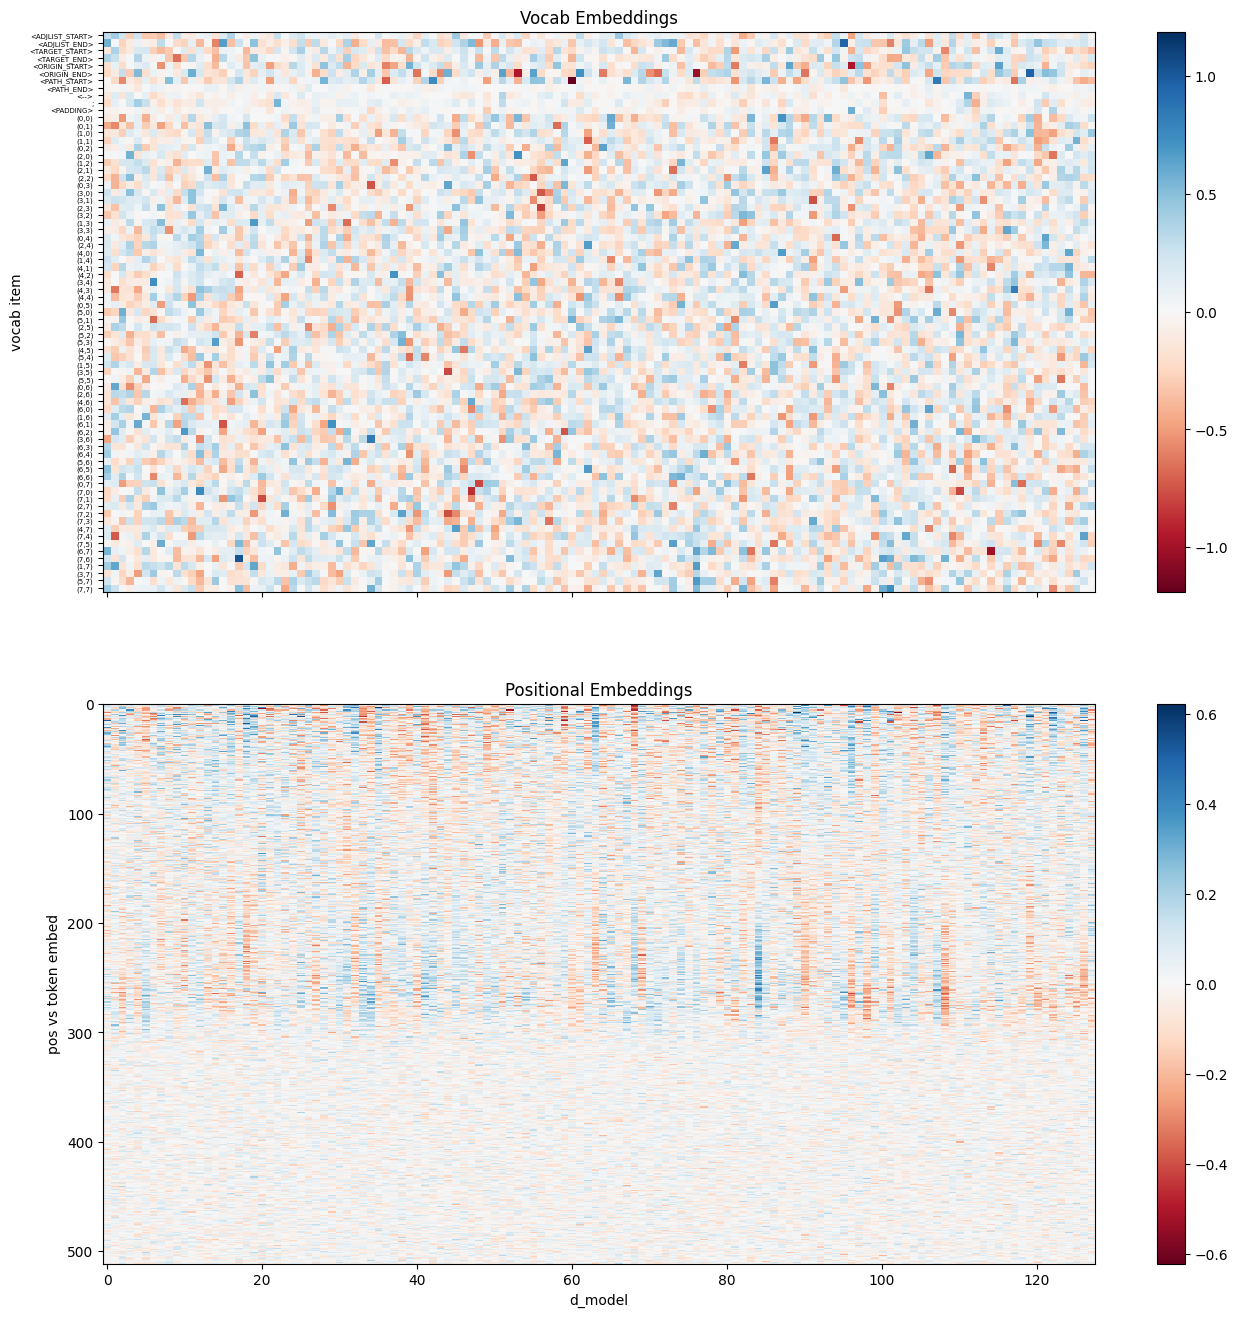

In [54]:
print(f"{MODEL.W_pos.shape = }")
print(f"{MODEL.W_E.shape = }")
print(f"{VOCAB_EMBEDS.shape = }")

fig, (ax_e, ax_pos) = plt.subplots(2, 1, figsize=(16, 16), sharex=True)

assert VOCAB_EMBEDS.shape[1] == d_model
vbound: float = VOCAB_EMBEDS.abs().max().item()

ax_e.imshow(VOCAB_EMBEDS.cpu().numpy(), cmap="RdBu", aspect="auto", vmin=-vbound, vmax=vbound)
ax_e.set_title("Vocab Embeddings")
ax_e.set_ylabel("vocab item")
ax_e.set_yticks(VOCAB_TOKENS.cpu().numpy(), labels=TOKENIZER.token_arr, fontsize=5)
fig.colorbar(ax_e.get_images()[0], ax=ax_e)


assert MODEL.W_pos.shape[1] == d_model

vbound_pos: float = MODEL.W_pos.abs().max().item()
ax_pos.imshow(
    MODEL.W_pos.cpu().numpy(),
	cmap="RdBu", aspect="auto",
    interpolation="none",
    vmin=-vbound_pos, vmax=vbound_pos,
)
fig.colorbar(ax_pos.get_images()[0], ax=ax_pos)
ax_pos.set_title("Positional Embeddings")
ax_pos.set_ylabel("pos vs token embed")
ax_pos.set_xlabel("d_model")


In [ ]:
# plot the PCA
def plot_pca_colored(
    pca_results: np.ndarray, 
    data: pd.DataFrame, 
    color_col: str, 
    dim1: int, 
    dim2: int
) -> None:
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    for col_val in data[color_col].unique():
        _temp: pd.Series = data[color_col] == col_val
        # this hacky bit to get binary columns to work
        _temp = _temp.fillna(False)
        boolean_index = _temp.to_numpy(dtype=bool)

        ax.scatter(
            pca_results[boolean_index, dim1-1], 
            pca_results[boolean_index, dim2-1], 
            alpha=0.5, 
            label=col_val,
        )
        
    ax.set_xlabel(f"PC{dim1}")
    ax.set_ylabel(f"PC{dim2}")
    ax.set_title(f"PCA of Survey Responses:\nPC{dim1} vs PC{dim2}\nColored by {color_col}")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Dropdown for color columns
color_column_dropdown = ipywidgets.Dropdown(
    options=DATA_INFO[DATA_INFO["categorical"]].index,
    description='Color by:',
    disabled=False,
)

# Dropdowns for PCA dimensions
dim1_dropdown = ipywidgets.IntText(
    value=1,
    description='Dim 1:',
    disabled=False
)

dim2_dropdown = ipywidgets.IntText(
    value=2,
    description='Dim 1:',
    disabled=False
)

ipywidgets.interact(
    plot_pca_colored, 
    pca_results=ipywidgets.fixed(x2d), 
    data=ipywidgets.fixed(DATA), 
    color_col=color_column_dropdown,
    dim1=dim1_dropdown,
    dim2=dim2_dropdown
);